# Example mini-project: Correlating molecular mass and NMR data

> **Note:** This project is an example with model answers to show you what level is expected for your assessment. Please do not try to submit this project for marking!

# Introduction

NMR data (here <sup>1</sup>H NMR) provide a powerful way to interpret chemical species, but generally require expert knowledge in order to fully analyse them. In other words, a computer cannot easily determine molecular structure based on an NMR pattern.

Despite this, there are many things that a computer can do with an NMR pattern, such as extracting peak positions and relative intensities (you will see software that can do this in labs). At its simplest these can serve as a molecular fingerprint to compare with databases of known molecules, but they can also be combined with other physical property data to create predictive models. For instance, the chemical shifts of <sup>1</sup>H NMR peaks can be used to predict pKa values for unknown molecules, which is particularly important for drug molecule design. Such models rely on lots of data (and often machine learning) which must be processed in an automated fashion.

# Project aim

In this project you will investigate whether the molecular mass of an unknown compound can be predicted from its NMR spectrum. You are provided with a file containing ID numbers and molecular weights for some unknown compounds (`data_sources/NMR_weights.csv`) and the corresponding NMR spectra (`data_sources/NMR_data/ID.txt`). 

# Task 1 : Loading the data [5 marks]

- Read in the `NMR_weights.csv` file for use later
- Write a function that can import an NMR spectrum
- Read in all spectra for later use

## Module imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## Read in data files


In [2]:
# Load NMR_weights.csv
summary = pd.read_csv('data_sources/NMR_weights.csv')
summary = summary.set_index('id')
summary.head()


molwt
id        
1   136.23
2   108.14
3   134.17
4   129.16
5   100.12

In [3]:
def load_NMR_spectrum(NMR):
    """ Read an NMR spectrum file and return a Pandas DataFrame of the contents. """
    
    data = pd.read_csv(NMR, sep='\t', names=['shift','intensity','derivative'])
    
    return data


Now, we can iterate through the summary id's in order to read in the data files. Data are stored as a dictionary with the format `{id: NMR_DataFrame}`


In [4]:
NMR_data = {}

for ID in summary.index:
    file = 'data_sources/NMR_data/' + str(ID) + '.txt' 
    NMR_data[ID] = load_NMR_spectrum(file)


# Task 2: Data exploration [12 marks]

Before trying to perform any sort of automated data analysis, it is good practice to check that the data are relatively similar in their numerical distribution. Plot histograms showing the distribution of:
- The chemical shift range covered in each NMR spectrum
- The maximum intensity of each pattern
- The standard deviation of the NMR baselines (i.e. the regions of the spectrum without any peaks)

In [5]:
def summary_statistics(NMR_data, ID):
    """ Return summary statistics for an NMR spectrum. 
    
    Parameters
    ----------
    NMR_data : dict
        Dictionary of NMR DataFrames, keyed by ID number. Each DataFrame
        should contain 'shift' and 'intensity' data columns
    ID : int
        Unique ID number of NMR spectrum
        
    Returns
    -------
    
    shift_range : float
        range (max - min) of chemical shifts observed in the NMR spectrum
    max_intensity : float
        Maximum intensity in NMR pattern
    baseline_std : float
        Standard deviation of the lowest 50% of intensity values   
    
    """
    
    # Calculate shift range
    min_shift = NMR_data[ID]['shift'].min()
    max_shift = NMR_data[ID]['shift'].max()
    shift_range = max_shift - min_shift

    # Calculate max intensity
    max_intensity = NMR_data[ID]['intensity'].max()

    # Calculate baseline
    num_points = NMR_data[ID].shape[0]
    baseline_std = NMR_data[ID]['intensity'].nsmallest(n = int(num_points*0.5)).std()
    
    return shift_range, max_intensity, baseline_std


In [6]:
# Generate statistics for each NMR spectrum in summary
for ID in summary.index:
    stats = summary_statistics(NMR_data, ID)
    summary.loc[ID, ['shift_range', 'max_int', 'baseline_std']] = stats


## Histograms


Text(0.5, 0, 'Chemical shift range')

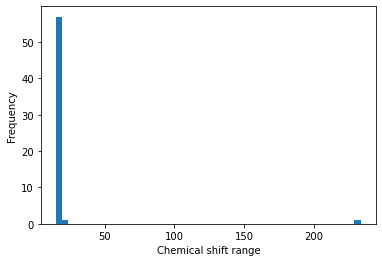

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
summary['shift_range'].plot(kind='hist', bins=50, ax=ax, label='ppm range')
ax.set_xlabel('Chemical shift range')


Text(0.5, 0, 'Maximum intensity')

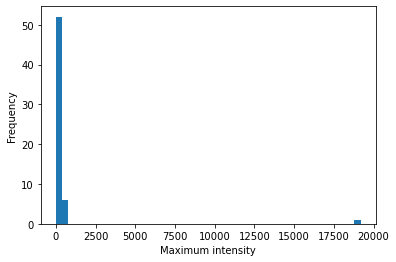

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
summary['max_int'].plot(kind='hist', bins=50, ax=ax, label='Maximum intensity')
ax.set_xlabel('Maximum intensity')


Text(0.5, 0, 'Baseline standard deviation')

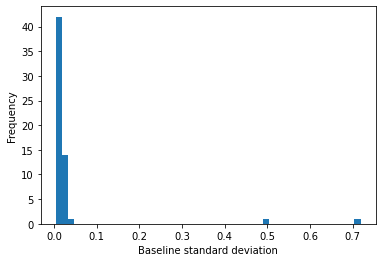

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
summary['baseline_std'].plot(kind='hist', bins=50, ax=ax, label='Baseline sigma')
ax.set_xlabel('Baseline standard deviation')


In [10]:
summary[summary['baseline_std'] > 0.3]


molwt  shift_range       max_int  baseline_std
id                                                 
12  165.15   233.786319     33.873833      0.496040
36  182.13    20.655757  19181.949219      0.718201

The histograms above show that most data occupy a relatively small range of chemical shifts and intensities, but two files are outliers to this trend: ID12 has a very large chemical shift range, while ID36 has a large maximum intensity. Both of these files also have anomalously large baseline standard deviations.


# Task 3: Data processing [2 marks]

Statistical analysis similar to that above shows that further analysis will be more robust if NMR intensities are normalised first (after all, NMR intensities are generally not quantitative).

- Normalise each of your NMR spectra such that the maximum intensity has a magnitude of 100.

In [11]:
for ID in summary.index:
    NMR_data[ID]['intensity'] = NMR_data[ID]['intensity'] / NMR_data[ID]['intensity'].max() * 100


# Task 4: NMR Peak finding [15 marks]

A number of different peak finding algorithms exist, but here we shall use `scipy.signal.find_peaks`, which works well with some parameter tweaking (in this case `prominence`).

- Write a function that can detect the number of peaks in an NMR spectrum
    - Your function should allow you to supply the prominence value as a parameter
- Test different values of prominence, and justify your chosen value
- If any patterns need to be removed as outliers, explain this with justification
- For each spectrum, calculate (and retain) the number of peaks for later analysis

In [12]:
from scipy.signal import find_peaks

def count_peaks(NMR_data, ID, prominence):
    """ Return the number of peaks in an NMR spectrum. """
    
    peaks, peak_info = find_peaks(NMR_data[ID]['intensity'],
                                  prominence = prominence,
                                  )
    
    return len(peaks)


## Prominence testing

The code below tests different values of prominence for each NMR pattern, and plots how the number of peaks varies. From the figure it is clear that the number of peaks is stable for prominence > 0.9, so a value of prominence is chosen for further analyses.

Note that ID = 12 is an outlier in that it produces hundreds (if not thousands) of peaks for all prominence values tested. This can be explained by the very noisy baseline (see below). As such, this pattern is removed from further analysis.


In [13]:
prominence_range = np.arange(0.1, 5, 0.2)

# Make an empty DataFrame with 'prominence value' as the row index and 'ID' as the columns
prom_testing = pd.DataFrame(index=prominence_range, columns=summary.index)

for prom in prom_testing.index:
    for ID in prom_testing.columns:
        prom_testing.loc[prom, ID] = count_peaks(NMR_data, ID, prom)


Text(0, 0.5, 'Number of detected peaks')

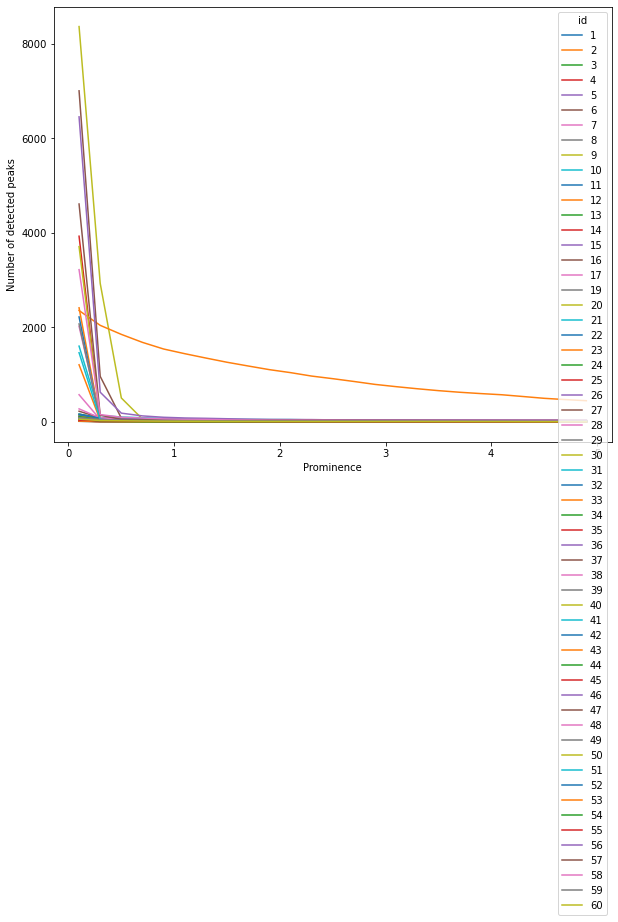

In [14]:
ax = prom_testing.plot(figsize=(10,8))
ax.set_xlabel('Prominence')
ax.set_ylabel('Number of detected peaks')


Text(0, 0.5, 'Normalised intensity')

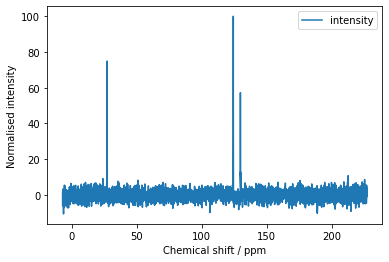

In [15]:
ax = NMR_data[12].plot(x='shift', y='intensity')
ax.set_xlabel('Chemical shift / ppm')
ax.set_ylabel('Normalised intensity')


In [16]:
# Remove the outlying data set
summary.drop(12, inplace=True)


In [17]:
# Calculate number of peaks using optimum prominence value
for ID in summary.index:
    summary.loc[ID,'num_peaks'] = count_peaks(NMR_data, ID, prominence=1)


# Analysis and conclusions [6 marks]

Now you have determined the number of peaks in each NMR pattern, use this information to plot a graph of  molecular weight vs. number of peaks. Your graph should include a linear least-squares fit line and the Pearson R coefficient.

From these results, what can you conclude about the correlation between number of NMR peaks and molecular weight for these data?

In [18]:
from scipy.stats import linregress


In [19]:
fit = linregress(summary['num_peaks'], summary['molwt'])


Text(0, 0.5, 'Molecular Weight (g mol$^{-1}$)')

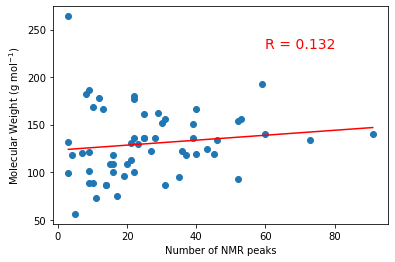

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(summary['num_peaks'], summary['molwt'])
xvals = np.linspace(summary['num_peaks'].min(), summary['num_peaks'].max(), 100)
ax.plot(xvals, fit.intercept + fit.slope*xvals, 'r', label='fitted line')
ax.text(60, 230, f"R = {fit.rvalue:.3f}", color='red', fontsize=14)
ax.set_xlabel('Number of NMR peaks')
ax.set_ylabel('Molecular Weight (g mol$^{-1}$)')


From these data we can conclude that there is little correlation between the number of NMR peaks and molecular weight. This may be understood for a number of reasons, such as:
- The number of peaks arises from the protons, and does not take into account the number of other elements present.
- The number of unique peaks will be influenced by how many protons occupy the same chemical environment, which does not obviously relate to the number of atoms present in the molecule.

Future work could look at correlating the number of peaks with e.g. the number of protons or the number of different chemical functional groups, which may give a better overall correlation.
